In [3]:
from utils.position_encodings import SinusoidalPosEmb, RotaryPositionEncoding, RotaryPositionEncoding3D, RotaryPositionEncoding2D
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import get_masks
from utils.clip import load_clip
from torchvision.ops import FeaturePyramidNetwork
import torch.nn.functional as F
from sklearn.decomposition import PCA
import einops

vis_backbone, normalize = load_clip()

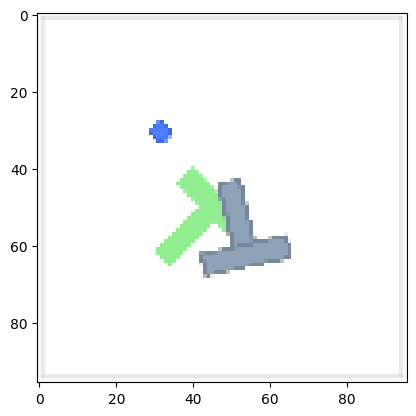

In [4]:
img = np.load('data/dummy_obs.npy').transpose(1, 2, 0)
masks = get_masks(img)
plt.imshow(img)
plt.show()

In [5]:
img = torch.from_numpy(np.load('data/obs_0.npy')).unsqueeze(0)
print("img.shape", img.shape)

embedding_dim = 60

img = normalize(img)
img_features = vis_backbone(img)

feature_pyramid = FeaturePyramidNetwork(
            [64, 256, 512, 1024, 2048], embedding_dim)


feature_map_pyramid = ['res2', 'res1', 'res1', 'res1']
img_feature_pyramid = feature_pyramid(img_features)

print("img_feature_pyramid", img_feature_pyramid.keys())
for i, fm in enumerate(feature_map_pyramid):
    print(f"level {i}, shape: {img_feature_pyramid[fm].shape}, downscale: {img.shape[-1]/img_feature_pyramid[fm].shape[-1]}")

img.shape torch.Size([1, 3, 96, 96])
img_feature_pyramid odict_keys(['res1', 'res2', 'res3', 'res4', 'res5'])
level 0, shape: torch.Size([1, 60, 24, 24]), downscale: 4.0
level 1, shape: torch.Size([1, 60, 48, 48]), downscale: 2.0
level 2, shape: torch.Size([1, 60, 48, 48]), downscale: 2.0
level 3, shape: torch.Size([1, 60, 48, 48]), downscale: 2.0


In [6]:
positions = np.meshgrid(np.arange(img.shape[-1]), np.arange(img.shape[-2]))
positions = np.stack(positions, axis=-1)
positions = torch.from_numpy(positions).unsqueeze(0).float()

rotary_pe_encoder = RotaryPositionEncoding2D(embedding_dim)
rotary_pe = rotary_pe_encoder(positions.reshape(img.shape[0], -1, 2))
print("rotary_pe.shape", rotary_pe.shape)

img_features = F.interpolate(img_feature_pyramid['res1'], size=(img.shape[-2], img.shape[-1]), mode='bilinear', align_corners=False)
img_features = img_features.permute(0, 2, 3, 1).reshape(img.shape[0], -1, embedding_dim)
print("img_features.shape", img_features.shape)

cos, sin = rotary_pe[..., 0], rotary_pe[..., 1]
img_embedding = RotaryPositionEncoding.embed_rotary(img_features.reshape(1, -1, embedding_dim), cos, sin)
print("img_embedding.shape", img_embedding.shape)

rotary_pe.shape torch.Size([1, 9216, 60, 2])
img_features.shape torch.Size([1, 9216, 60])
img_embedding.shape torch.Size([1, 9216, 60])


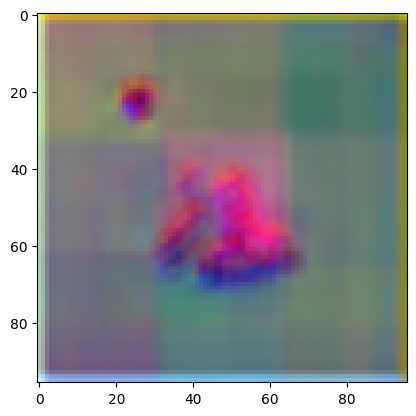

In [7]:
img_features = F.interpolate(img_feature_pyramid['res1'], size=(img.shape[-2], img.shape[-1]), mode='bilinear', align_corners=False)
img_features = img_features.permute(0, 2, 3, 1).detach().numpy()
pca = PCA(n_components=3)
pca.fit(img_features.reshape(-1, embedding_dim))
pca_activation = pca.transform(img_features.reshape(-1, embedding_dim)).reshape(img_features.shape[1:3]+(3,))
pca_activation = (pca_activation - pca_activation.min()) / (pca_activation.max() - pca_activation.min())
plt.imshow(pca_activation)
plt.show()

## Temporally embed images
1. Use a learnable embedding for each timestep

In [25]:
im1 = np.load('data/obs_0.npy')
im2 = np.load('data/obs_1.npy')

obs_horizon = 2

images = np.stack([im1, im2], axis=0).reshape(1, obs_horizon, *im1.shape)
images = torch.from_numpy(images).float()

images = normalize(images)
img_features = vis_backbone(images.reshape(-1, *images.shape[-3:]))
img_feature_pyramid = feature_pyramid(img_features)
img_features = F.interpolate(img_feature_pyramid['res1'], size=(img.shape[-2], img.shape[-1]), mode='bilinear', align_corners=False)
img_features = einops.rearrange(img_features, '(b t) c h w -> b t (h w) c', t=obs_horizon)

time_encoder = nn.Embedding(obs_horizon, embedding_dim)
img_embedding = img_features + time_encoder.weight.unsqueeze(0).unsqueeze(2)

cos, sin = rotary_pe[..., 0], rotary_pe[..., 1]
img_embedding = einops.rearrange(img_embedding, 'b t n c -> (b t) n c')
img_embedding = RotaryPositionEncoding.embed_rotary(img_embedding, cos, sin)
print("img_embedding.shape", img_embedding.shape)

img_embedding.shape torch.Size([2, 9216, 60])


2. Use 1D SinusoidalPosEmb

In [27]:
time_encoder = SinusoidalPosEmb(embedding_dim)
time_embedding = time_encoder(torch.arange(obs_horizon))
print("time_embedding.shape", time_embedding.shape)

img_embedding = img_features + time_embedding.unsqueeze(0).unsqueeze(-2)
print("img_embedding.shape", img_embedding.shape)

cos, sin = rotary_pe[..., 0], rotary_pe[..., 1]
img_embedding = einops.rearrange(img_embedding, 'b t n c -> (b t) n c')
img_embedding = RotaryPositionEncoding.embed_rotary(img_embedding, cos, sin)
print("img_embedding.shape", img_embedding.shape)

time_embedding.shape torch.Size([2, 60])
img_embedding.shape torch.Size([1, 2, 9216, 60])
img_embedding.shape torch.Size([2, 9216, 60])
